In [5]:
import matplotlib.pyplot as plt
import polars as pl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [6]:
basics = pl.read_parquet(
    "C:/Users/leonardo.ferraz/Documents/Leonardo Ferraz/BigDataSenac/projetofinal/parquets/title.basics_POLARS.parquet"
)

ratings = pl.read_parquet(
    "C:/Users/leonardo.ferraz/Documents/Leonardo Ferraz/BigDataSenac/projetofinal/parquets/title.ratings_POLARS.parquet"
)


In [7]:
basics_sel = basics.select([
    "tconst",
    "startYear",
    "genres"
])

ratings_sel = ratings.select([
    "tconst",
    "numVotes"
])


In [8]:
df = basics_sel.join(
    ratings_sel,
    on="tconst",
    how="inner"
)


In [9]:
df = df.filter(
    (pl.col("startYear").is_not_null()) &
    (pl.col("numVotes") > 0)
)


In [10]:
print(df.columns)
df.head()


['tconst', 'startYear', 'genres', 'numVotes']


tconst,startYear,genres,numVotes
str,i64,str,i64
"""tt0000001""",1894,"""Documentary,Short""",2188
"""tt0000002""",1892,"""Animation,Short""",307
"""tt0000003""",1892,"""Animation,Comedy,Romance""",2274
"""tt0000004""",1892,"""Animation,Short""",197
"""tt0000005""",1893,"""Short""",3012


In [11]:
def regressao_genero(df, genero):
    df_gen = df.filter(pl.col("genres").str.contains(genero))

    if df_gen.height < 10:
        return None, None

    serie = (
        df_gen
        .group_by("startYear")
        .agg(pl.col("numVotes").mean().alias("avg_votes"))
        .sort("startYear")
    )

    df_pd = serie.to_pandas()

    X = df_pd[["startYear"]]
    y = df_pd["avg_votes"]

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)
    coef = model.coef_[0]

    resultado = {
        "Genero": genero,
        "Coeficiente": coef,
        "R2": r2,
        "Tendencia": (
            "Crescimento" if coef > 0 else
            "Queda" if coef < 0 else
            "Estavel"
        )
    }

    return resultado, serie


In [12]:
generos = [
    "Action",
    "Comedy",
    "Drama",
    "Horror",
    "Romance",
    "Animation"
]

resultados = []
series_temporais = {}

for genero in generos:
    resultado, serie = regressao_genero(df, genero)
    if resultado:
        resultados.append(resultado)
        series_temporais[genero] = serie


In [13]:
for r in resultados:
    print("=" * 50)
    print(f"Gênero: {r['Genero']}")
    print(f"Tendência: {r['Tendencia']}")
    print(f"Coeficiente (inclinação): {r['Coeficiente']:.2f}")
    print(f"R² (qualidade do modelo): {r['R2']:.3f}")

    if r["R2"] >= 0.7:
        print("📈 Modelo forte")
    elif r["R2"] >= 0.4:
        print("📊 Modelo moderado")
    else:
        print("⚠️ Modelo fraco")


Gênero: Action
Tendência: Crescimento
Coeficiente (inclinação): 21.98
R² (qualidade do modelo): 0.525
📊 Modelo moderado
Gênero: Comedy
Tendência: Crescimento
Coeficiente (inclinação): 7.05
R² (qualidade do modelo): 0.291
⚠️ Modelo fraco
Gênero: Drama
Tendência: Crescimento
Coeficiente (inclinação): 14.11
R² (qualidade do modelo): 0.473
📊 Modelo moderado
Gênero: Horror
Tendência: Crescimento
Coeficiente (inclinação): 10.22
R² (qualidade do modelo): 0.023
⚠️ Modelo fraco
Gênero: Romance
Tendência: Crescimento
Coeficiente (inclinação): 10.76
R² (qualidade do modelo): 0.164
⚠️ Modelo fraco
Gênero: Animation
Tendência: Crescimento
Coeficiente (inclinação): 4.50
R² (qualidade do modelo): 0.174
⚠️ Modelo fraco


In [16]:
def plot_genero(serie, genero, coef, r2):
    df_pd = serie.to_pandas()

    X = df_pd["startYear"]
    y = df_pd["avg_votes"]

    model = LinearRegression()
    model.fit(X.values.reshape(-1, 1), y)
    y_pred = model.predict(X.values.reshape(-1, 1))

    r2_pct = r2 * 100

    plt.figure(figsize=(10, 5))
    plt.scatter(X, y)
    plt.plot(X, y_pred)

    plt.title(
        f"{genero} — Tendência de Popularidade\n"
        f"R² = {r2:.3f} ({r2_pct:.1f}%)"
    )
    plt.xlabel("Ano")
    plt.ylabel("Média de votos")
    plt.grid(True)

    plt.show()


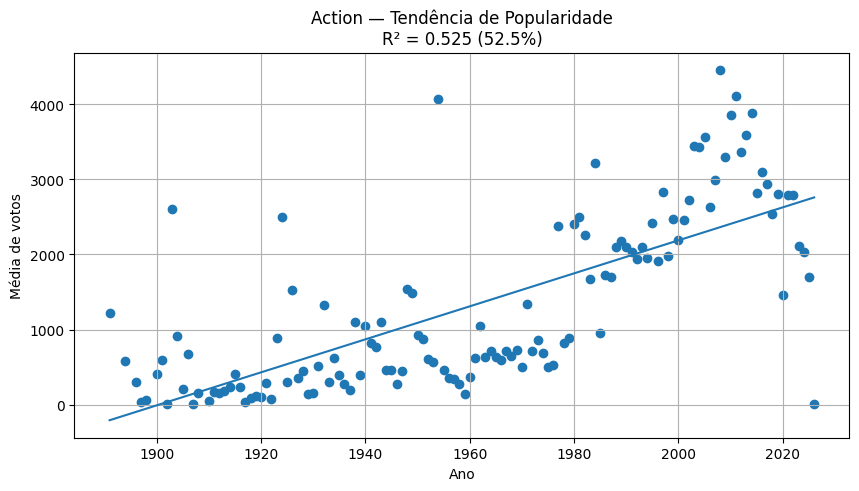

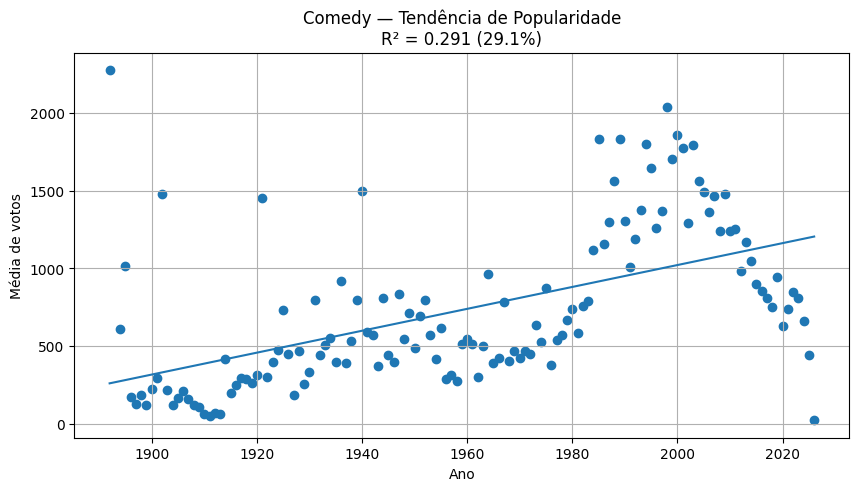

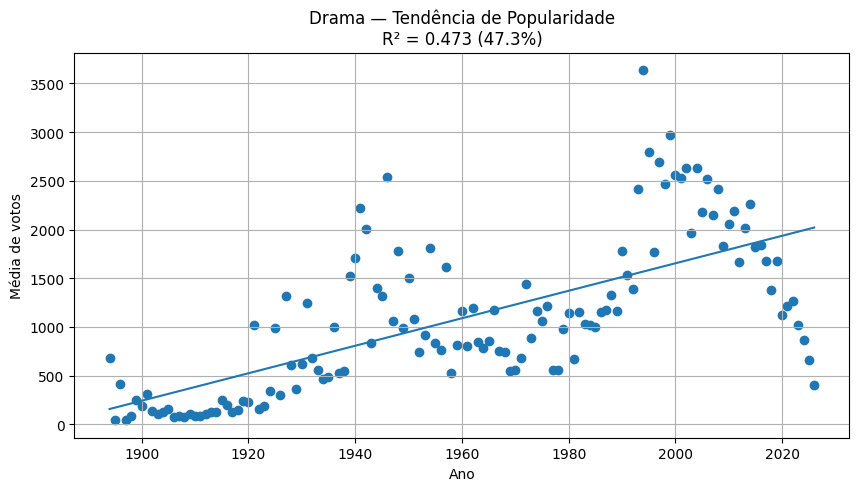

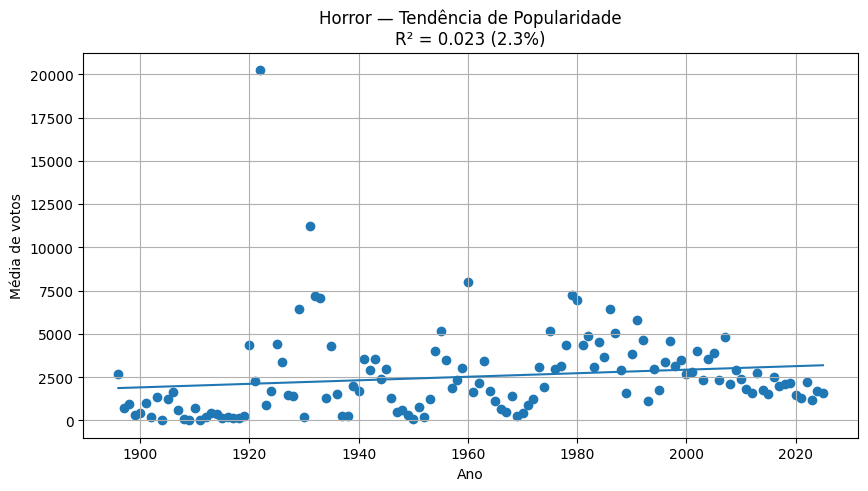

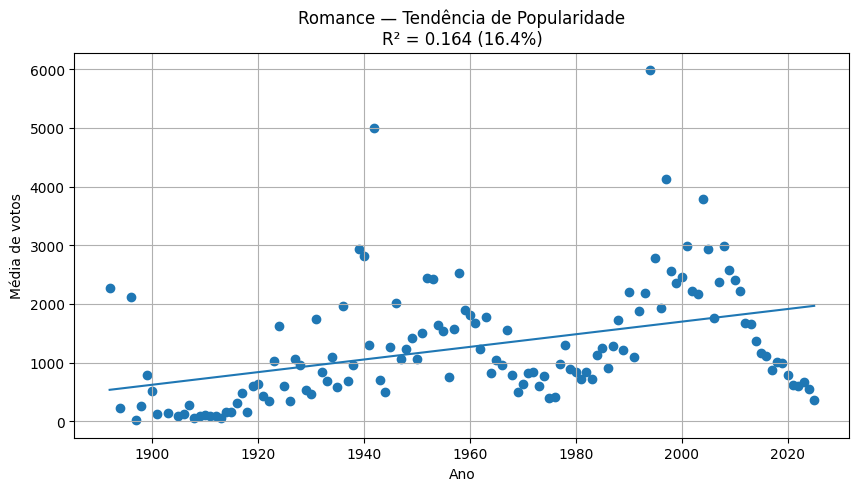

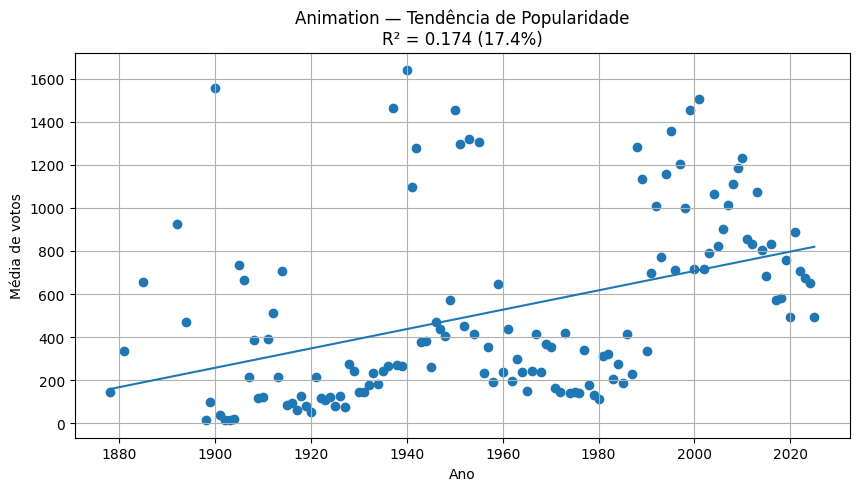

In [17]:
for r in resultados:
    genero = r["Genero"]
    coef = r["Coeficiente"]
    r2 = r["R2"]

    serie = series_temporais[genero]

    plot_genero(serie, genero, coef, r2)


In [36]:
basics_sel = (
    basics
    .filter(pl.col("titleType") == "movie")
    .select([
        "tconst",
        "primaryTitle",
        "startYear",
        "genres"
    ])
)


In [37]:
df = basics_sel.join(
    ratings_sel,
    on="tconst",
    how="inner"
)


In [38]:
def identificar_anos_pico(serie, n_desvios=1):
    media = serie["avg_votes"].mean()
    desvio = serie["avg_votes"].std()

    limite = media + n_desvios * desvio

    return (
        serie
        .filter(pl.col("avg_votes") > limite)
        .select(["startYear", "avg_votes"])
        .sort("startYear")
    )


In [43]:
def top_filmes_pico(df, genero, ano, top_n=1):
    return (
        df
        .filter(
            (pl.col("genres").str.contains(genero)) &
            (pl.col("startYear") == ano)
        )
        .select([
            "primaryTitle",
            "numVotes"
        ])
        .sort("numVotes", descending=True)
        .head(top_n)
        .with_columns([
            pl.lit(genero).alias("Genero"),
            pl.lit(ano).alias("Ano")
        ])
        .select([
            "Genero",
            "Ano",
            "primaryTitle",
            "numVotes"
        ])
    )


In [44]:
top_filmes_resultado = []

for r in resultados:
    genero = r["Genero"]
    serie = series_temporais[genero]

    anos_pico = identificar_anos_pico(serie)

    for row in anos_pico.iter_rows(named=True):
        ano = row["startYear"]

        top_df = top_filmes_pico(df, genero, ano)

        if top_df.height > 0:
            top_filmes_resultado.append(top_df)


In [45]:
df_top_filmes = pl.concat(top_filmes_resultado)
df_top_filmes


Genero,Ano,primaryTitle,numVotes
str,i32,str,i64
"""Action""",1924,"""Sherlock Jr.""",64261
"""Action""",1954,"""Seven Samurai""",396772
"""Action""",1981,"""Raiders of the Lost Ark""",1096710
"""Action""",1984,"""The Terminator""",986155
"""Action""",1997,"""Men in Black""",653490
…,…,…,…
"""Animation""",2007,"""Ratatouille""",917572
"""Animation""",2008,"""WALL·E""",1294865
"""Animation""",2009,"""Up""",1211924


In [46]:
for row in df_top_filmes.iter_rows(named=True):
    print(
        f"{row['Genero']} | {row['Ano']} | "
        f"{row['primaryTitle']} | votos: {row['numVotes']}"
    )


Action | 1924 | Sherlock Jr. | votos: 64261
Action | 1954 | Seven Samurai | votos: 396772
Action | 1981 | Raiders of the Lost Ark | votos: 1096710
Action | 1984 | The Terminator | votos: 986155
Action | 1997 | Men in Black | votos: 653490
Action | 2002 | Spider-Man | votos: 947747
Action | 2003 | Pirates of the Caribbean: The Curse of the Black Pearl | votos: 1298343
Action | 2004 | The Incredibles | votos: 881509
Action | 2005 | Batman Begins | votos: 1683820
Action | 2006 | 300 | votos: 903299
Action | 2007 | Pirates of the Caribbean: At World's End | votos: 733040
Action | 2008 | The Dark Knight | votos: 3104589
Action | 2009 | Avatar | votos: 1455251
Action | 2010 | Inception | votos: 2758879
Action | 2011 | Captain America: The First Avenger | votos: 952409
Action | 2012 | The Dark Knight Rises | votos: 1959206
Action | 2013 | Iron Man 3 | votos: 950403
Action | 2014 | Guardians of the Galaxy | votos: 1342889
Action | 2015 | Mad Max: Fury Road | votos: 1189594
Action | 2016 | Dead

series_csv = []

for genero, serie in series_temporais.items():
    temp = (
        serie
        .with_columns(pl.lit(genero).alias("Genero"))
        .select([
            "Genero",
            pl.col("startYear").alias("Ano"),
            pl.col("avg_votes").alias("AvgVotes")
        ])
    )
    series_csv.append(temp)

df_series_pb = pl.concat(series_csv)

df_series_pb.write_csv("pb_series_temporais_generos.csv")


df_resultados_pb = pl.DataFrame([
    {
        "Genero": r["Genero"],
        "Coeficiente": r["Coeficiente"],
        "R2": r["R2"],
        "R2_pct": r["R2"] * 100,
        "Tendencia": r["Tendencia"]
    }
    for r in resultados
])

df_resultados_pb.write_csv("pb_resultados_regressao.csv")


df_top_filmes.write_csv("pb_top_filmes_anos_pico.csv")
